# Training with Distance Weight

In [20]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score

# created library
import mydata
from mymodels import TransDataset, LoadDataset, EfficientB3Model
import training

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# to reproduce

seed = 42
random.seed(seed) #　ほかのモジュールで使われているかも
np.random.seed(seed) # ほかのモジュールで使われているかも
torch.manual_seed(seed) # Pytorchの中のシード
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True # GPUの計算過程の変化をさせない

In [21]:
db = "UTKFace"
root = f"../../dataset/AAAI 2025/{db}/"
polynomial_save_file = f"{root}model/pickle/polynomial_model_ef3.pkl"

# Load model
with open(polynomial_save_file, "rb") as f:
    polynomial_model = pickle.load(f)

Validation_MEAN = 0.93

In [22]:
# Test
polynomial_model(np.array([45, 50]))

array([0.97294449, 0.97735784])

In [23]:
df_train = mydata.load_and_process_csv(f"{root}/dataframe/df_train.csv")
df_valid = mydata.load_and_process_csv(f"{root}/dataframe/df_valid.csv")
df_test = mydata.load_and_process_csv(f"{root}/dataframe/df_test.csv")

In [24]:
def calculate_distance_penalty(distances):
    diff = polynomial_model(np.array(distances)) - Validation_MEAN
    diff = torch.tensor(diff.mean())
    return diff

In [54]:
ycol="labels"
batch_size = 1 # １インプットずつペナルティを付加するため

ld = LoadDataset(df_train, df_valid, df_test, ycol, batch_size)
train_loader, valid_loader, test_loader = ld.create_dataloaders()

H*W:  (200, 200)


In [84]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

class CustomBCEWithLogitsLoss(nn.Module):
    def __init__(self):
        super(CustomBCEWithLogitsLoss, self).__init__()

    def forward(self, outputs, targets, distances, device): # criterion
        #print("outputs", outputs[0])
        outputs = outputs.view(-1)
        #print("targets", targets)
        bce_loss = F.binary_cross_entropy(torch.sigmoid(outputs), targets) # due to batch size=1
        #bce_loss = F.binary_cross_entropy(torch.sigmoid(outputs), targets)
        penalty = calculate_distance_penalty(distances).to(device)
        #print("bce_loss", bce_loss)
        #print("penalty", penalty)
        penalty = penalty * 0.0000001
        return bce_loss + penalty

In [85]:
def train_model(model, train_loader, valid_loader, num_epochs=25, lr=1e-5, weight_decay=1e-4):

    train_losses = []
    valid_losses = []
    train_f1s = []
    valid_f1s = []
    train_aucs = []
    valid_aucs = []
    train_accuracies = []
    valid_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    criterion = CustomBCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for inputs, labels, distances in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) # data -> GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            #loss = criterion(outputs.squeeze(), labels, distances, device)
            loss = criterion(outputs, labels, distances, device) # due to batch size=1
            loss.backward() # Partial Derivative
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            all_preds.extend(outputs.detach().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_f1 = f1_score(all_labels, [1 if x >= 0 else 0 for x in all_preds])
        epoch_auc = roc_auc_score(all_labels, all_preds)
        epoch_acc = accuracy_score(all_labels, [1 if x >= 0 else 0 for x in all_preds])

        train_losses.append(epoch_loss)
        train_f1s.append(epoch_f1)
        train_aucs.append(epoch_auc)
        train_accuracies.append(epoch_acc)

        #print(f'Epoch {epoch}/{num_epochs - 1} | Loss: {epoch_loss:.4f} | F1: {epoch_f1:.4f} | AUC: {epoch_auc:.4f}')
        
        model.eval() # Validation だから。
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for inputs, labels, distances in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device) # data -> GPU
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels, distances, device)
                
                val_loss += loss.item() * inputs.size(0)
                val_preds.extend(outputs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(valid_loader.dataset)
        val_f1 = f1_score(val_labels, [1 if x >= 0.5 else 0 for x in val_preds])
        val_auc = roc_auc_score(val_labels, val_preds)
        val_acc = accuracy_score(val_labels, [1 if x >= 0.5 else 0 for x in val_preds])

        valid_losses.append(val_loss)
        valid_f1s.append(val_f1)
        valid_aucs.append(val_auc)
        valid_accuracies.append(val_acc)

        print(f'Validation Accuracy: {val_acc:.4f} | Loss: {val_loss:.4f} | F1: {val_f1:.4f} | AUC: {val_auc:.4f}')

    epochs = range(num_epochs)
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Valid Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_f1s, label='Train F1 Score')
    plt.plot(epochs, valid_f1s, label='Valid F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score')
    plt.legend()

    plt.show()

Validation Accuracy: 0.4966 | Loss: 1.2150 | F1: 0.0506 | AUC: 0.5835
Validation Accuracy: 0.4945 | Loss: 1.7047 | F1: 0.0082 | AUC: 0.6303
Validation Accuracy: 0.5340 | Loss: 0.8629 | F1: 0.1551 | AUC: 0.7540
Validation Accuracy: 0.5042 | Loss: 0.7053 | F1: 0.0468 | AUC: 0.7433
Validation Accuracy: 0.5038 | Loss: 0.7540 | F1: 0.0498 | AUC: 0.7970
Validation Accuracy: 0.5336 | Loss: 0.6677 | F1: 0.1627 | AUC: 0.8137
Validation Accuracy: 0.5285 | Loss: 0.9317 | F1: 0.1599 | AUC: 0.7813
Validation Accuracy: 0.5147 | Loss: 0.7580 | F1: 0.1134 | AUC: 0.8208
Validation Accuracy: 0.5562 | Loss: 1.0934 | F1: 0.3954 | AUC: 0.7572
Validation Accuracy: 0.5407 | Loss: 0.7777 | F1: 0.2536 | AUC: 0.7798
Validation Accuracy: 0.5201 | Loss: 1.5007 | F1: 0.1921 | AUC: 0.8110
Validation Accuracy: 0.5403 | Loss: 0.7966 | F1: 0.1722 | AUC: 0.8144
Validation Accuracy: 0.5814 | Loss: 0.6093 | F1: 0.3211 | AUC: 0.8605
Validation Accuracy: 0.5591 | Loss: 3.1931 | F1: 0.3386 | AUC: 0.7731
Validation Accuracy:

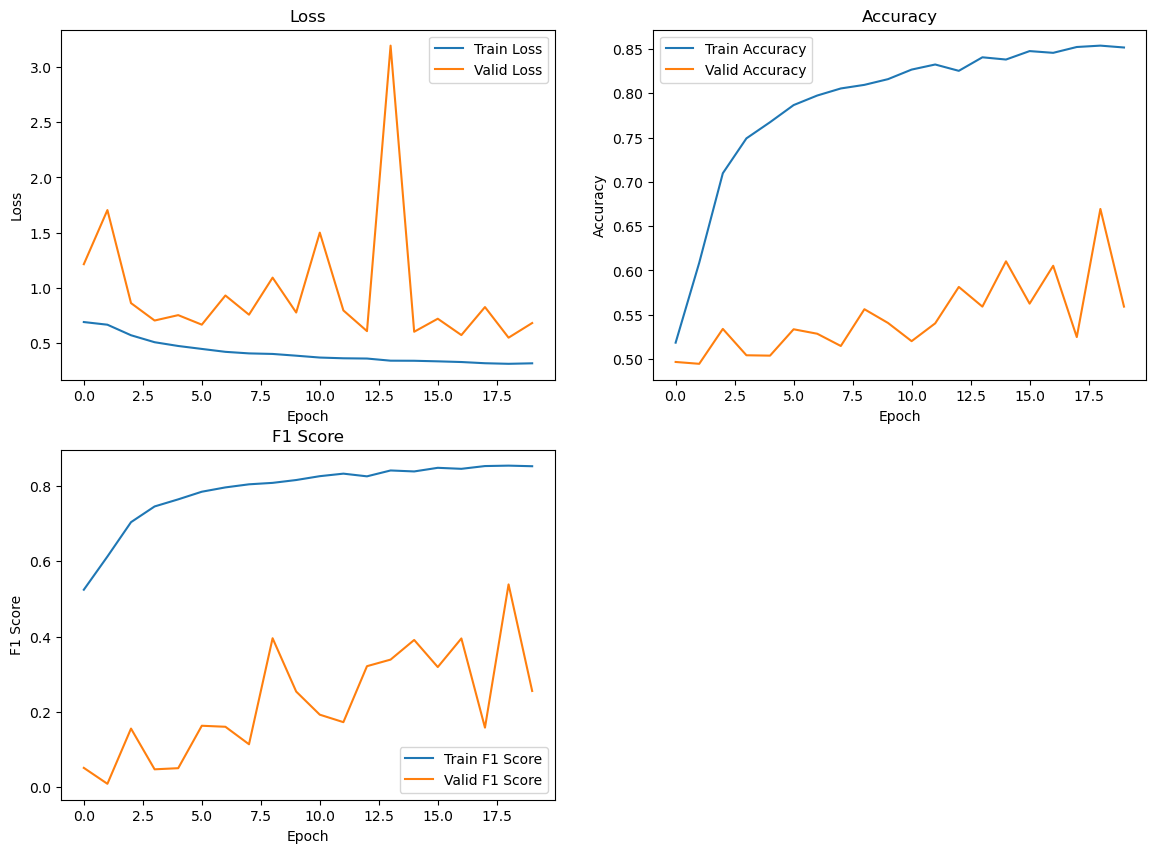

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientB3Model().to(device) # model -> GPU

num_epochs = 20
lr = 0.00001
train_model(model, train_loader, valid_loader, num_epochs=num_epochs, lr=lr)

In [ ]:
def evaluate_model(model, valid_loader):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval() # 評価モードに入る。dropoutは学習にしか使わない。dropoutはノイズを入れている。ノイズに耐えられるように。
    with torch.no_grad():
        test_predictions = []
        test_outputs = []
        for inputs, labels, _ in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device) # data -> GPU
            outputs = model(inputs)
            # _, test_predictions = torch.max(outputs, 1) # outputsの大きい方が選ばれるけど、二値分類なので異なる
            test_outputs.append(outputs)
            test_predictions.extend(1 if x >= 0 else 0 for x in outputs) # Appendは１つ、extendは複数
    
    return test_predictions

In [ ]:
test_predictions = evaluate_model(model, valid_loader)

In [ ]:
df["predictions"] = test_predictions

In [ ]:
train.test_classification_report(df_valid)